In [1]:
import csv
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import sup_func as sfu
import geograph as geo
import geopandas as gpd
%matplotlib inline

#I get the df from website worldometers.info

url_popu = 'https://www.worldometers.info/world-population/population-by-country/'
url_covid = 'https://www.worldometers.info/coronavirus/#countries'
r_popu = requests.get(url_popu)
r_covid = requests.get(url_covid)
soup_popu = BeautifulSoup(r_popu.content)
soup_covid = BeautifulSoup(r_covid.content)
countries_popu = soup_popu.find_all('table')[0]
countries_covid = soup_covid.find_all('table')[0]
df_popu = pd.read_html(str(countries_popu))[0]
df_covid = pd.read_html(str(countries_covid))[0]
df_popu.head()

,#,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,1,China,1439323776,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,2,India,1380004385,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,3,United States,331002651,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,4,Indonesia,273523615,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,5,Pakistan,220892340,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %


In [2]:
df_covid.head()

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop
0,World,3105224,"+42,709",214372.0,"+2,923",944116.0,1946736,56060.0,398.0,27.5,NaN,NaN
1,USA,1022259,"+11,903",57862.0,"+1,065",139927.0,824470,14145.0,3088.0,175.0,5782027.0,17468.0
2,Spain,232128,"+2,706",23822.0,+301,123903.0,84403,7764.0,4965.0,510.0,1345560.0,28779.0
3,Italy,201505,"+2,091",27359.0,+382,68941.0,105205,1863.0,3333.0,453.0,1846934.0,30547.0
4,France,165842,NaN,23293.0,NaN,45513.0,97036,4608.0,2541.0,357.0,463662.0,7103.0


In [3]:
#I get the columns that I want to use from df_popu

df_raw = pd.DataFrame({'A' : []})
df_raw['Country (or dependency)'] = df_popu['Country (or dependency)']
df_raw['Population (2020)'] = df_popu['Population (2020)']
df_raw['Density (P/Km²)'] = df_popu['Density (P/Km²)']
df_raw['Land Area (Km²)'] = df_popu['Land Area (Km²)']
df_raw['Migrants (net)'] = df_popu['Migrants (net)']
df_raw['Med. Age'] = df_popu['Med. Age']
df_raw['Urban Pop %'] = df_popu['Urban Pop %']
df_raw = df_raw.dropna(how='all',axis=1)
df_raw.head()

,Country (or dependency),Population (2020),Density (P/Km²),Land Area (Km²),Migrants (net),Med. Age,Urban Pop %
0,China,1439323776,153,9388211,-348399.0,38,61 %
1,India,1380004385,464,2973190,-532687.0,28,35 %
2,United States,331002651,36,9147420,954806.0,38,83 %
3,Indonesia,273523615,151,1811570,-98955.0,30,56 %
4,Pakistan,220892340,287,770880,-233379.0,23,35 %


In [4]:

#After checking both countries columns, I try match both columns with below dictionary
country_dic = {'USA':'United States', 'UK':'United Kingdom', 'S. Korea':'South Korea', 'UAE':'United Arab Emirates',
               'Czechia':'Czech Republic (Czechia)', 'Ivory Coast':"Côte d'Ivoire", 'DRC':'DR Congo',
               'Palestine':'State of Palestine', 'CAR':'Central African Republic', 'Saint Kitts and Nevis':'Saint Kitts & Nevis',
               'St. Vincent Grenadines':'St. Vincent & Grenadines', 'Vatican City':'Holy See', 'St. Barth':'Saint Barthelemy',
               'Sao Tome and Principe':'Sao Tome & Principe', 'Saint Pierre Miquelon':'Saint Pierre & Miquelon'}
df_covid['Country (or dependency)'] = df_covid['Country,Other']
df_covid.replace({'Country (or dependency)': country_dic},  inplace = True)
#I remove the columns from df_covid that I am not interested in 
df_subs = df_covid.drop([df_covid.columns[8],'Country,Other','NewCases','NewDeaths','ActiveCases','Serious,Critical','Tests/ 1M pop','Deaths/1M pop'],axis=1)
df_subs.head()

,TotalCases,TotalDeaths,TotalRecovered,TotalTests,Country (or dependency)
0,3105224,214372.0,944116.0,NaN,World
1,1022259,57862.0,139927.0,5782027.0,United States
2,232128,23822.0,123903.0,1345560.0,Spain
3,201505,27359.0,68941.0,1846934.0,Italy
4,165842,23293.0,45513.0,463662.0,France


In [5]:
#I join both tables using as index the country
df_raw = df_raw.join(df_subs.set_index('Country (or dependency)'), on='Country (or dependency)')
df_raw.head()

,Country (or dependency),Population (2020),Density (P/Km²),Land Area (Km²),Migrants (net),Med. Age,Urban Pop %,TotalCases,TotalDeaths,TotalRecovered,TotalTests
0,China,1439323776,153,9388211,-348399.0,38,61 %,82836.0,4633.0,77555.0,NaN
1,India,1380004385,464,2973190,-532687.0,28,35 %,29451.0,939.0,7137.0,716733.0
2,United States,331002651,36,9147420,954806.0,38,83 %,1022259.0,57862.0,139927.0,5782027.0
3,Indonesia,273523615,151,1811570,-98955.0,30,56 %,9511.0,773.0,1254.0,79618.0
4,Pakistan,220892340,287,770880,-233379.0,23,35 %,14514.0,312.0,3233.0,157223.0


In [6]:
#I have called dtypes to check where I have non-numeric columns to change its type.
df_raw.dtypes

Country (or dependency)     object
Population (2020)            int64
Density (P/Km²)              int64
Land Area (Km²)              int64
Migrants (net)             float64
Med. Age                    object
Urban Pop %                 object
TotalCases                 float64
TotalDeaths                float64
TotalRecovered             float64
TotalTests                 float64
dtype: object

In [7]:
#lets start for Urban POP, I change % values to floats, 100% is 1 0% is 0
indexes = df_raw.index.values.tolist()
for index in indexes:
    per = df_raw.loc[index,'Urban Pop %']
    if per == 'N.A.':
        df_raw.loc[index,'Urban Pop %'] = np.nan
    else:
        if type(per) is str:
            if per == '0 %':
                df_raw.loc[index,'Urban Pop %'] = 0
            else:
                df_raw.loc[index,'Urban Pop %'] = int(per[0:2])/100

df_raw = df_raw.astype({'Urban Pop %': 'float64'})
#Now I change the countries name to a number and replace the name with the number in the df
countries_list = df_raw['Country (or dependency)'].unique()
countries_list.sort()
countries_dic = dict()
k=0
for country in countries_list:
    countries_dic[country] = k
    k +=1
dic_reverse = {}
for key,values in countries_dic.items():
    dic_reverse[values] = key

df_raw.replace({'Country (or dependency)': countries_dic},  inplace = True)
#the last one is the Med Age. I change to a numeric, using coerce (imput NAN to errors)
df_raw['Med. Age'] = pd.to_numeric(df_raw['Med. Age'],errors='coerce')
df_raw.dtypes

Country (or dependency)      int64
Population (2020)            int64
Density (P/Km²)              int64
Land Area (Km²)              int64
Migrants (net)             float64
Med. Age                   float64
Urban Pop %                float64
TotalCases                 float64
TotalDeaths                float64
TotalRecovered             float64
TotalTests                 float64
dtype: object

In [8]:
#I am going to add a column of countries with free healthcare, migth be usefull
df_healthcare = pd.read_csv('countries with free healthcare.csv')
hc_edit = {'Czech Republic':'Czech Republic (Czechia)',
           'Macau':'Macao',
           'Saint Vincent and the Grenadines':'St. Vincent & Grenadines'}
df_healthcare.replace({'name': hc_edit},  inplace = True)
df_healthcare['free healthcare'] = 1
df_healthcare.drop(['pop2020'], axis=1, inplace=True)
df_healthcare.replace({'name': countries_dic},  inplace = True)
df_healthcare.head()

,name,free healthcare
0,1,1
1,2,1
2,4,1
3,7,1
4,8,1


In [9]:
df_raw = df_raw.join(df_healthcare.set_index('name'), on='Country (or dependency)')
df_raw['free healthcare'].fillna(0, inplace=True)

#now I am ready with my df, everything is a number

df_raw.dtypes

Country (or dependency)      int64
Population (2020)            int64
Density (P/Km²)              int64
Land Area (Km²)              int64
Migrants (net)             float64
Med. Age                   float64
Urban Pop %                float64
TotalCases                 float64
TotalDeaths                float64
TotalRecovered             float64
TotalTests                 float64
free healthcare            float64
dtype: object

In [10]:
#3 possible evaluations, TotalCases, TotalDeaths and TotalRecovered
casos = ['TotalCases','TotalDeaths','TotalRecovered']
for caso in casos:
    X, y = sfu.edit_df(df_raw,caso)
    r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)
    print("{} case: The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(caso,r2_scores_train,r2_scores_test))
    

TotalCases case: The rsquared on the training data was 0.8887885919371492.  The rsquared on the test data was -0.09408046879402843.
TotalDeaths case: The rsquared on the training data was 0.3601867677943227.  The rsquared on the test data was 0.5719859971590913.
TotalRecovered case: The rsquared on the training data was 0.5983446703197106.  The rsquared on the test data was 0.7156736276148664.


In [11]:
X, y = sfu.edit_df(df_raw, 'TotalRecovered')
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)

coef_df = sfu.coef_weights(lm_model.coef_, X_train)
coef_df

,est_int,coefs,abs_coefs
6,Urban Pop %,3205.593529,3205.593529
8,free healthcare,2380.137187,2380.137187
5,Med. Age,117.864684,117.864684
0,Country (or dependency),-9.427952,9.427952
2,Density (P/Km²),-0.213353,0.213353
7,TotalTests,0.022417,0.022417
4,Migrants (net),0.021685,0.021685
3,Land Area (Km²),-0.002508,0.002508
1,Population (2020),0.000042,0.000042


In [12]:
X, y = sfu.edit_df(df_raw, 'TotalCases')
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)

coef_df = sfu.coef_weights(lm_model.coef_, X_train)
coef_df

,est_int,coefs,abs_coefs
8,free healthcare,-2010.378427,2010.378427
6,Urban Pop %,1498.361685,1498.361685
5,Med. Age,-676.026175,676.026175
0,Country (or dependency),-35.800055,35.800055
4,Migrants (net),0.218658,0.218658
2,Density (P/Km²),-0.200832,0.200832
7,TotalTests,0.135733,0.135733
3,Land Area (Km²),-0.015264,0.015264
1,Population (2020),0.000150,0.000150


In [13]:
X, y = sfu.edit_df(df_raw, 'TotalDeaths')
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = sfu.get_stat_data(X,y)

coef_df = sfu.coef_weights(lm_model.coef_, X_train)
coef_df

,est_int,coefs,abs_coefs
6,Urban Pop %,908.500353,908.500353
8,free healthcare,206.503107,206.503107
5,Med. Age,31.844558,31.844558
0,Country (or dependency),-4.029515,4.029515
2,Density (P/Km²),-0.874714,0.874714
7,TotalTests,0.006368,0.006368
3,Land Area (Km²),-0.000819,0.000819
4,Migrants (net),0.000770,0.000770
1,Population (2020),0.000005,0.000005


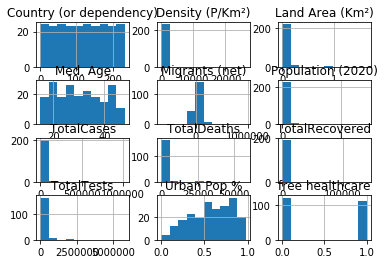

In [14]:
df_raw.hist();

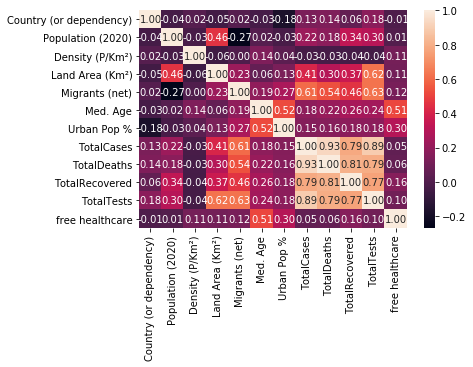

In [15]:
sns.heatmap(df_raw.corr(), annot= True, fmt='.2f');

In [16]:
df_chart = pd.DataFrame()
df_chart2 = pd.DataFrame()
df_chart3 = pd.DataFrame()
df_chart4 = pd.DataFrame()
df_c = pd.DataFrame()
dic_fh = {1: 'Yes', 0:'No'}
df_raw.head()

,Country (or dependency),Population (2020),Density (P/Km²),Land Area (Km²),Migrants (net),Med. Age,Urban Pop %,TotalCases,TotalDeaths,TotalRecovered,TotalTests,free healthcare
0,43,1439323776,153,9388211,-348399.0,38.0,0.61,82836.0,4633.0,77555.0,NaN,1.0
1,96,1380004385,464,2973190,-532687.0,28.0,0.35,29451.0,939.0,7137.0,716733.0,0.0
2,224,331002651,36,9147420,954806.0,38.0,0.83,1022259.0,57862.0,139927.0,5782027.0,0.0
3,97,273523615,151,1811570,-98955.0,30.0,0.56,9511.0,773.0,1254.0,79618.0,0.0
4,158,220892340,287,770880,-233379.0,23.0,0.35,14514.0,312.0,3233.0,157223.0,1.0


In [17]:
df_chart['Free Healthcare'] = df_raw['free healthcare']
df_chart['Population (2020)'] = df_raw['Population (2020)']
df_chart['TotalCases'] = df_raw['TotalCases']
df_chart.replace({'Free Healthcare':dic_fh}, inplace = True)
grouped_df = df_chart.groupby('Free Healthcare').sum()
grouped_df['Cases per 1M P'] = (grouped_df['TotalCases']*1e6)/grouped_df['Population (2020)']

In [18]:
grouped_df

,Population (2020),TotalCases,Cases per 1M P
Free Healthcare,,,
No,3966933941,1153307.0,290.730074
Yes,3827864798,1951196.0,509.734827


In [19]:
df_chart2['Free Healthcare'] = df_raw['free healthcare']
df_chart2['Population (2020)'] = df_raw['Population (2020)']
df_chart2['TotalDeaths'] = df_raw['TotalDeaths']
df_chart2.replace({'Free Healthcare':dic_fh}, inplace = True)
grouped_df2 = df_chart2.groupby('Free Healthcare').sum()
grouped_df2['Deaths per 1M P'] = (grouped_df2['TotalDeaths']*1e6)/grouped_df2['Population (2020)']

In [20]:
grouped_df2

,Population (2020),TotalDeaths,Deaths per 1M P
Free Healthcare,,,
No,3966933941,63386.0,15.978587
Yes,3827864798,150971.0,39.440003


In [21]:
df_chart3['Free Healthcare'] = df_raw['free healthcare']
df_chart3['Population (2020)'] = df_raw['Population (2020)']
df_chart3['TotalRecovered'] = df_raw['TotalRecovered']
df_chart3.replace({'Free Healthcare':dic_fh}, inplace = True)
grouped_df3 = df_chart3.groupby('Free Healthcare').sum()
grouped_df3['Recovered per 1M P'] = (grouped_df3['TotalRecovered']*1e6)/grouped_df3['Population (2020)']

In [22]:
grouped_df3

,Population (2020),TotalRecovered,Recovered per 1M P
Free Healthcare,,,
No,3966933941,175275.0,44.183998
Yes,3827864798,767602.0,200.530071


In [23]:
df_c['Free Healthcare'] = df_raw['free healthcare']
df_c.replace({'Free Healthcare':dic_fh}, inplace = True)
df_c['Population (2020)'] = df_raw['Population (2020)']
group_dfc2 = df_c.groupby('Free Healthcare').agg({'count','sum'})
df_c['TotalCases'] = df_raw['TotalCases']
df_c['TotalDeaths'] = df_raw['TotalDeaths']
df_c['TotalRecovered'] = df_raw['TotalRecovered']
df_c['TotalTests'] = df_raw['TotalTests']
group_dfc = df_c.groupby('Free Healthcare').sum()
group_dfc['Tests per 1M P']= (group_dfc['TotalTests']*1e6)/group_dfc['Population (2020)']
group_dfc['Cases per 1M P']= (group_dfc['TotalCases']*1e6)/group_dfc['Population (2020)']
group_dfc['Deaths per 100 Cases'] = (group_dfc['TotalDeaths']*100)/group_dfc['TotalCases']
group_dfc['Recovered per 100 Cases'] = (group_dfc['TotalRecovered']*100)/group_dfc['TotalCases']
rate_expected = group_dfc.loc['No','Cases per 1M P']/group_dfc.loc['Yes','Cases per 1M P']


In [24]:
group_dfc

,Population (2020),TotalCases,TotalDeaths,TotalRecovered,TotalTests,Tests per 1M P,Cases per 1M P,Deaths per 100 Cases,Recovered per 100 Cases
Free Healthcare,,,,,,,,,
No,3966933941,1153307.0,63386.0,175275.0,8277506.0,2086.625621,290.730074,5.496021,15.197601
Yes,3827864798,1951196.0,150971.0,767602.0,21573249.0,5635.844038,509.734827,7.737357,39.340077


In [25]:
group_dfc2

Population (2020)            
                            count         sum
Free Healthcare                              
No                            123  3966933941
Yes                           112  3827864798

In [26]:
x = 122387238913
y= sfu.popu_cifra(x) 
y

'122.39B'

In [27]:
sns.set(style='whitegrid', palette='pastel', color_codes=True)

In [28]:
sns.mpl.rc('figure', figsize=(10,6))

In [29]:
#opening the vector map
shp_path = 'World_Countries.shp'
#reading the shape file by using reader function of the shape lib
sf = shp.Reader(shp_path)

In [30]:
len(sf.shapes())

252

In [31]:
sf.records()

    


[Record #0: ['Aruba (Netherlands)'],
 Record #1: ['Antigua and Barbuda'],
 Record #2: ['Afghanistan'],
 Record #3: ['Algeria'],
 Record #4: ['Azerbaijan'],
 Record #5: ['Albania'],
 Record #6: ['Armenia'],
 Record #7: ['Andorra'],
 Record #8: ['Angola'],
 Record #9: ['American Samoa (US)'],
 Record #10: ['Argentina'],
 Record #11: ['Australia'],
 Record #12: ['Austria'],
 Record #13: ['Anguilla (UK)'],
 Record #14: ['Antarctica'],
 Record #15: ['Bahrain'],
 Record #16: ['Barbados'],
 Record #17: ['Botswana'],
 Record #18: ['Bermuda (UK)'],
 Record #19: ['Belgium'],
 Record #20: ['Bahamas'],
 Record #21: ['Bangladesh'],
 Record #22: ['Belize'],
 Record #23: ['Bosnia and Herzegovina'],
 Record #24: ['Bolivia'],
 Record #25: ['Myanmar'],
 Record #26: ['Benin'],
 Record #27: ['Belarus'],
 Record #28: ['Solomon Islands'],
 Record #29: ['Brazil'],
 Record #30: ['Bhutan'],
 Record #31: ['Bulgaria'],
 Record #32: ['Bouvet Island (Norway)'],
 Record #33: ['Brunei'],
 Record #34: ['Burundi'],
 R

In [32]:
df = sfu.read_shapefile(sf)

In [33]:
df.head()

,COUNTRY,coords
0,Aruba (Netherlands),"[(-69.88223266601562, 12.411109924316406), (-6..."
1,Antigua and Barbuda,"[(-61.7388916015625, 17.54055404663086), (-61...."
2,Afghanistan,"[(61.27655792236328, 35.60724639892578), (61.2..."
3,Algeria,"[(-5.152134895324707, 30.180469512939453), (-5..."
4,Azerbaijan,"[(46.540374755859375, 38.875587463378906), (46..."


In [34]:
com_id = df.index[df['COUNTRY'] == 'Spain'][0]


In [35]:
com_id

202

In [36]:
sf.shape(com_id)

(-5.743250096259274, 37.851965252497024)

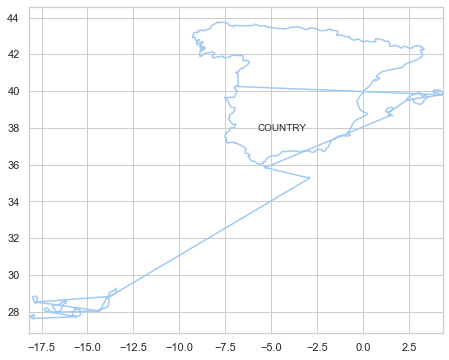

In [37]:
geo.plot_shape(com_id, sf, 'COUNTRY')

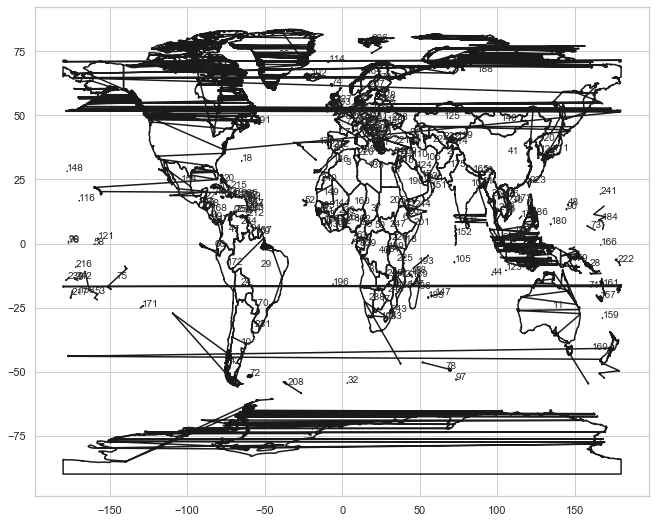

In [38]:
geo.plot_map(sf)

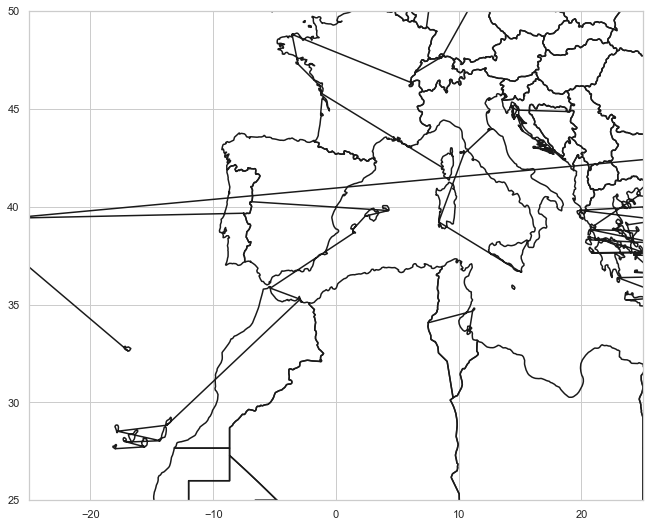

In [39]:
y_lim = (25,50) 
# latitude
x_lim = (-25, 25) 
# longitude
geo.plot_map(sf, x_lim, y_lim)

<Figure size 792x648 with 0 Axes>

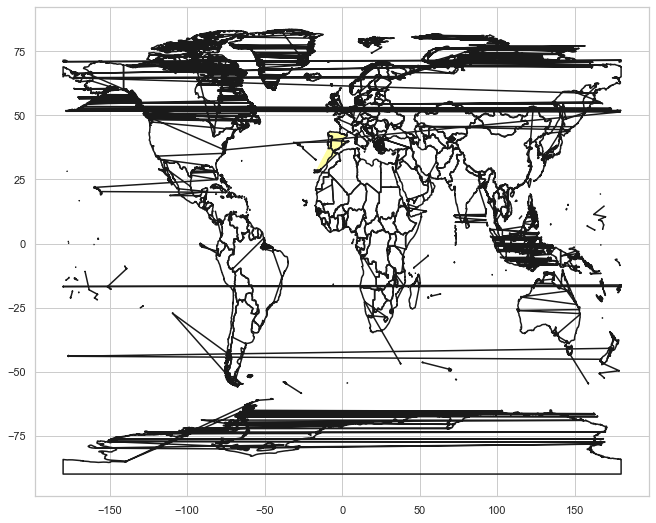

In [40]:
geo.plot_map_fill(com_id, sf, color='y')

<Figure size 792x648 with 0 Axes>

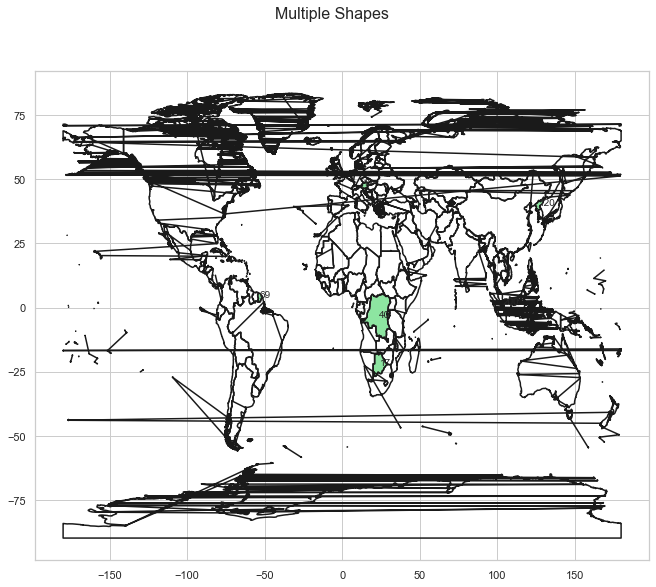

In [41]:
country_id = [12,17,40,69,120,200]
geo.plot_map_fill_multiples_ids('Multiple Shapes',country_id, sf, color = 'g')


1: 100 => 265

2: 266 => 365

3: 366 => 499

4: 500 => 599

5: 600 => 1999

6: 2000 => 399999


   1   2   3   4   5   6


NameError: name 'read_shapefile' is not defined

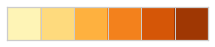

In [42]:
names = ['Azerbaijan','Angola','Australia', 'Spain', 'United States']
data = [100, 2000, 300, 400000, 500, 600, 100, 2000, 300, 400, 500, 600, 100, 2000, 300, 400, 500, 600]
print_id = True 
# The shape id will be printed
color_pallete = 'Purple'
geo.plot_countries_data(sf, 'Heat map of given countries', names, data, color_pallete, print_id)

In [ ]:
df.tail(15)


In [ ]:
# set the filepath and load
fp = 'World_Countries.shp'
#reading the file stored in variable fp
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

In [ ]:
map_df.plot()

In [ ]:
df = gpd.read_file(fp)